In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Housekeeping Gene Pairing

Author: John Vivian

Read in housekeeping gene list taken from the paper [Human Housekeeping Genes, Revisited](http://dx.doi.org/10.1016/j.tig.2013.05.010), which can be found on their [supplementary page](https://www.tau.ac.il/~elieis/HKG/).

In [30]:
hk = pd.read_csv('HK_genes.txt', sep='\t', header=None)
hk.columns = ['gene', 'refSeqId']
hk.head(2)

,gene,refSeqId
0,AAAS,NM_015665
1,AAGAB,NM_024666


We'll now pair it to the ENSEMBL gene names using attribute information. The attribute file can be pulled from [Synapse](www.synapse.org) using the id: `syn7248857`.

In [18]:
attr = pd.read_csv('attrs.tsv', sep='\t')
attr.head(2)

,geneId,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000456328.2,DDX11L1-002,processed_transcript,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000362751.1,NaN,2,pseudo
1,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,KNOWN,ENST00000450305.2,DDX11L1-001,transcribed_unprocessed_pseudogene,KNOWN,OTTHUMG00000000961.2,OTTHUMT00000002844.2,NaN,2,pseudo


Create dictionary mapping geneId to GeneName

In [23]:
gene_map = {}
for i in attr.index:
    gene_map[attr.loc[i].geneName] = attr.loc[i].geneId

Create dataframe of Ensembl Id, geneName

In [36]:
hk_genes = [x.strip() for x in hk.gene]
ens_ids = []
for gene in hk_genes:
    try:
        ens_ids.append(gene_map[gene])
    except KeyError:
        ens_ids.append(np.nan)

In [41]:
df = pd.DataFrame()
df['hk_gene'] = hk_genes
df['gene_id'] = ens_ids
df.head(2)

,hk_gene,gene_id
0,AAAS,ENSG00000094914.12
1,AAGAB,ENSG00000103591.12


How many hk_gene's are we missing an ENSG id for?

In [45]:
print 'Total Number of hk genes: ' + str(len(df))
print 'Number of missing ENSG ids: ' + str(len(df[pd.isnull(df.gene_id)]))

Total Number of hk genes: 3804
Number of missing ENSG ids: 57


Save the dataframe

In [50]:
df.to_csv('hk_genes.tsv', sep='\t')

## Compare to GTEx "All vs All"

Differential expression was run between all tisuses of GTEx - we'll compare the results from this analysis with the literature results.

Experimental design for this DE was: "Group was the broad tissue type. Eg `group<-c(brain, adipose, ovary, brain,...)`"

In [53]:
gtex = pd.read_csv('allVsAll.tsv', sep='\t', index_col=0)

In [77]:
gtex = gtex.sort_values('PValue')
gtex.head()

,logFC,logCPM,F,PValue
ENSG00000185231.4,5.276308,4.291967,4392.500223,0.0
ENSG00000185559.13,2.587887,5.555445,2126.169758,0.0
ENSG00000148795.5,1.962417,5.743916,4817.744019,0.0
ENSG00000163646.10,4.893440,4.198657,3260.657202,0.0
ENSG00000122584.12,4.674667,4.816628,3983.953540,0.0


Housekeeping genes should be uniform and 
Subset dataframe to keep everything with |fold change| < 2 and pval > 0.05

In [241]:
hk_gtex = gtex[(np.absolute(gtex.logFC) < 1) & (gtex.PValue > 0.01)]
hk_gtex.head()

,logFC,logCPM,F,PValue
ENSG00000145416.13,-0.128456,6.224269,101.769607,0.010001
ENSG00000143546.9,-0.123879,6.277935,12.665578,0.010007
ENSG00000100211.10,0.118076,6.355920,346.578391,0.010013
ENSG00000187607.15,0.126493,6.196813,224.918519,0.010016
ENSG00000105953.14,0.104822,6.698630,328.064705,0.010021


Compare set intersection of genes

print 'Number of genes in gtex hk set: ' + str(len(hk_gtex))
print 'Number of genes in hk literature set: ' + str(len(hk_genes))
print 'Number of protein-coding genes: ' + str(len(gtex))

In [243]:
lit_set = set(ens_ids)
lit_set.remove(np.nan)
gtex_set = set(hk_gtex.index)

In [244]:
len(gtex_set)

10866

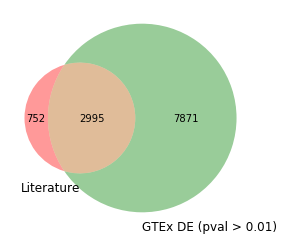

In [245]:
venn2((lit_set, gtex_set), set_labels=('Literature', 'GTEx DE (pval > 0.01)'), alpha=0.4)
plt.savefig('Housekeeping_venn|.pdf', format='pdf')

## Hypergeometric Significance Test

[Info on the hypergeometric distribution](http://homepages.ulb.ac.be/~dgonze/TEACHING/hypergeom.pdf)

[Probability Calculator](https://www.geneprof.org/GeneProf/tools/hypergeometric.jsp)

Given the hypergeometric distribution
$$P(x \mid N,m,k) = \frac{{{m}\choose{x}}{{N-m}\choose{k-x}}}{N\choose{k}}$$

we can compute the chance of _at least some value x_ by

$$P(\mbox{at least x} \mid N,m,k) = 1 - \sum_{i=0}^{x-1}P(i \mid N,m,k)$$

For our case

$$ N = \mbox{Total number of genes} = 19,741 $$
$$ m = \mbox{Literature housekeeping genes} = 3,804 $$
$$ k = \mbox{Housekeeping genes from DE} = 10,866 $$
$$ x = \mbox{intersection} = 2,995$$

Which gives

$$P(X >= 2,995) = 2.4 x 10^{-252}$$

Questions:

    What types of genes make up the set differences and the intersection?
    Why might have DE found so many more housekeeping genes than the literature?
    Can a heuristic be imposed onto the DE data such that it more closely resembles the literature set?